<a href="https://colab.research.google.com/github/hkaragah/google_colab_repo/blob/main/hands_on_ml_exercises/09_unsupervised_learning_mini_batch_kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mini Batch K-Means

__Disclaimer:__ This exercise is adopted from `"Hands-on Machine Learning with Scikit-Learn, Keras & Tensorflow (Third Edition)"` book written by `_Aurelien Geron_` publoshed by `_O'Reilly_`. I broke them down into smaller digestable snippets, made some modifications, and added some explanations so that I can undersatand them better. The porpuse of this notebook is just for me to understand the concept and have hands-on practice while reading the book material.

## Objective
Clustring MNIST dataset using `MiniBatchKMeans`

## Import Dependencies

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import accuracy_score, silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
import matplotlib
print(matplotlib.__version__)
print(sns.__version__)

3.9.2
0.13.2


# Create Dataset

In [ ]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False, parser='auto')
X_train, y_train, X_test, y_test = mnist.data[:60000], mnist.target[:60000], mnist.data[60000:], mnist.target[60000:]

The `numpy.memmap` is used to create memory-mapped arrays. This allows you to handle large datasets efficiently by storing the array data on disk instead of in memory, while still being able to work with the data as if it's in memory.<br>

### Key Features:
* __Memory efficiency:__ `np.memmap` allows you to access parts of a large array without loading the entire dataset into memory. This is useful when dealing with datasets that are too large to fit into RAM.

* __Partial I/O:__ You can read and write small sections of a large file, so you only load what you need, improving both memory usage and speed.

* __Persistent storage:__ The data is stored on disk, so changes made to the memory-mapped array can be written back to the file for later use.

### Parameters:
* `filename`: The path to the file on disk where the array is stored or will be created.

* `dtype`: Data type of the array (e.g., `float`, `int`, etc.).

* `mode`: Specifies how to open the file:
  * `'r'`: Read-only.
  * `'r+'`: Read/write mode.
  * `'w+'`: Create or overwrite a file for reading and writing.
  * `'c'`: Copy-on-write mode (changes are not written to the file).

* `offset`: Number of bytes to skip at the beginning of the file.
shape: The shape of the array.

* `order`: Memory layout of the array, either row-major (`'C'`) or column-major (`'F'`).

### Use Cases:
* __Handling large datasets:__ `np.memmap` is useful when you're working with large datasets that don't fit into memory but still need fast access.

* __Partial updates:__ You can update parts of a large dataset stored on disk without reading the entire file into memory.

* __Saving intermediate results:__ When running long computations that generate large datasets, you can save intermediate results to disk using memory-mapped arrays.

In [ ]:
filename = "my_mnist.mmap"

X_memmap = np.memmap(filename, dtype='float32', mode='w+', shape=X_train.shape)
X_memmap[:] = X_train
# Flush memory changes to disk in order to read them back
X_memmap.flush()

In [ ]:
X_memmap.flags.writeable

True

In [ ]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=10, batch_size=5120, n_init=3, random_state=42)
minibatch_kmeans.fit(X_memmap)

MiniBatchKMeans(batch_size=5120, n_clusters=10, n_init=3, random_state=42)

Let's plot the _inertia_ and _time_ of fitting the `MNIST` dataset into `KMeans` and `MiniBatchKMeans`.

In [ ]:
from timeit import timeit

max_k = 10
times = np.empty((max_k, 2))
inertias = np.empty((max_k, 2))

for k in range(1, max_k+1):
    kmeans = KMeans(n_clusters=k, algorithm='lloyd', n_init=10, random_state=42)
    mb_kmeans = MiniBatchKMeans(n_clusters=k, n_init=10, batch_size=5120, random_state=42)
    print('Training k-means with k = {}...'.format(k))
    times[k-1, 0] = timeit(lambda: kmeans.fit(X_memmap), number=10, globals=globals())
    print('Training mini-batch k-means with k = {}...'.format(k))
    times[k-1, 1] = timeit(lambda: mb_kmeans.fit(X_memmap), number=10, globals=globals())
    inertias[k-1, 0] = kmeans.inertia_
    inertias[k-1, 1] = mb_kmeans.inertia_

Training k-means with k = 1...
Training mini-batch k-means with k = 1...
Training k-means with k = 2...
Training mini-batch k-means with k = 2...
Training k-means with k = 3...
Training mini-batch k-means with k = 3...
Training k-means with k = 4...
Training mini-batch k-means with k = 4...
Training k-means with k = 5...
Training mini-batch k-means with k = 5...
Training k-means with k = 6...
Training mini-batch k-means with k = 6...
Training k-means with k = 7...
Training mini-batch k-means with k = 7...
Training k-means with k = 8...
Training mini-batch k-means with k = 8...
Training k-means with k = 9...
Training mini-batch k-means with k = 9...
Training k-means with k = 10...
Training mini-batch k-means with k = 10...


Let's plot intertia-vs-k and time-vs-k for both `KMeans` and `MiniBatchKMeans` models.

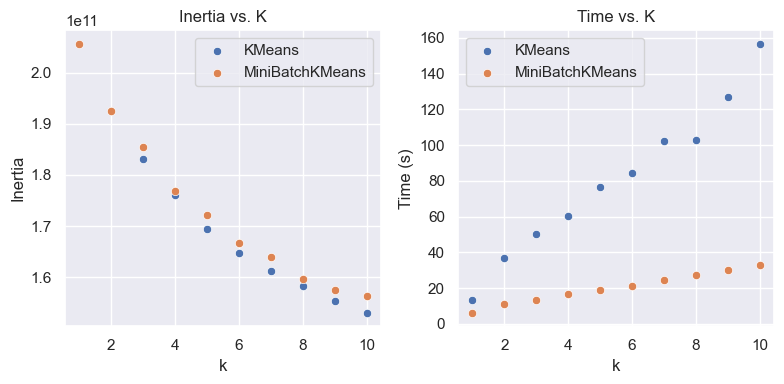

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

sns.scatterplot(x=range(1, max_k+1), y=inertias[:, 0], marker='o', label='KMeans', ax=ax[0])
sns.scatterplot(x=range(1, max_k+1), y=inertias[:, 1], marker='o', label='MiniBatchKMeans', ax=ax[0])
ax[0].set_xlabel('k')
ax[0].set_ylabel('Inertia')
ax[0].set_title('Inertia vs. K')
ax[0].legend()

sns.scatterplot(x=range(1, max_k+1), y=times[:, 0], marker='o', label='KMeans', ax=ax[1])
sns.scatterplot(x=range(1, max_k+1), y=times[:, 1], marker='o', label='MiniBatchKMeans', ax=ax[1])
ax[1].set_xlabel('k')
ax[1].set_ylabel('Time (s)')
ax[1].set_title('Time vs. K')
ax[1].legend()


plt.tight_layout()
plt.show()